#### Building Transformers

In [3]:
import torch
import torch.nn as nn
import math

### Dataset -> Language Translation

In [4]:
# The dataset used converts english to italian language.

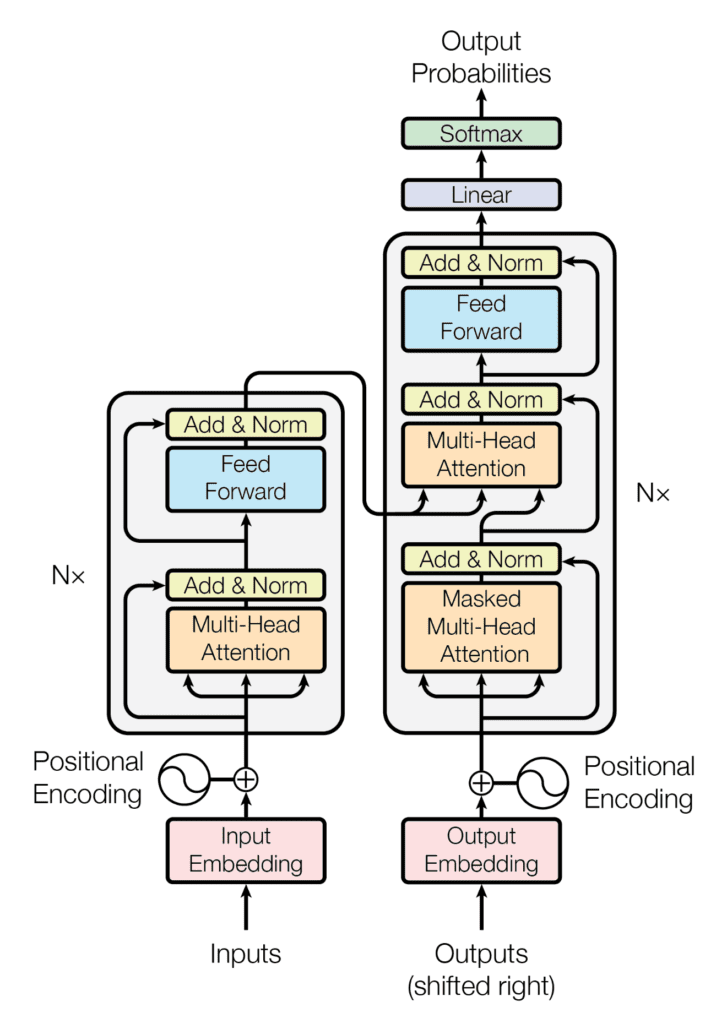

#### Step-1: - Input Embedding
This is the first part, It takes the input and coverts it into usable embeddings(text to numbers). <br>
First we assign each text a token( a number in vocabulary), then we use an embedding model to create an embedding.

In [ ]:
# Handle the input embeddings first........
class InputEmbedding(nn.Module):
    def __init__(self, dimension_size, vocab_size):
        super().__init__()
        # The dimension size is the size of the embedding vector for each word. d_model in the paper.
        self.dimension_size = dimension_size
        
        # The vocab size is the total number of unique words in the vocabulary.
        self.vocab_size = vocab_size
        
        # The embedding layer, provided by pytorch can be used to create embeddings.
        self.embedding_layer = nn.Embedding(self.vocab_size, self.dimension_size)
        
    # The forward pass takes the input and passes it through the embedding layer.
    def forward_pass(self, x_input):
        output = self.embedding_layer(x_input) * math.sqrt(self.dimension_size) # Here we multiply the output by sqrt(d_model) as mentioned in the paper.
        return output

#### Step-2: - Positional Encoding
Since we have converted now text to embeddings, we want to add some position information, that tells the model the information about the position of the word in a sentence. 

In [ ]:
class PositionalEncoding(nn.Module):
    
    def __init__(self, dimension_size :int, max_length:int = 5000, dropout:float = 0.1):
        
        super().__init__()
        # The dimension size is the size of the embedding vector for each word. d_model in the paper.
        self.dimension_size = dimension_size
        # The max length is the maximum length of the input sequence.
        self.max_length = max_length
        # The dropout layer to prevent overfitting.
        self.dropout = nn.Dropout(dropout)
        
        # Now the goal is to build a matrix of size (max_length, dimension_size) to hold the positional encodings.
        
        pc_enc_matrix = torch.zeros(self.max_length, self.dimension_size) # Initialize the matrix with zeros.
        
        # Formula for positional encoding:
        # PE(pos, 2i) = sin(pos / (10000^(2i/d_model)))             # Even indices
        # PE(pos, 2i+1) = cos(pos / (10000^(2i/d_model)))           # Odd indices
        
        # We are using log space to make numerical stability. We have just changed the formula a bit, by taking log of the denominator.
        
        # Step-1: - Create a position vector of shape (max_length, 1)
        position = torch.arange(0, self.max_length, dtype=torch.float).unsqueeze(1) # Shape (max_length, 1); this is the pos in the formula
        
        # Step-2: - let us create the div_term(denominator term) of shape (dimension_size/2)
        div_term = torch.exp(torch.arange(0, dimension_size, 2).float() * (-math.log(10000.0) / dimension_size)) 
        # Shape (dimension_size/2); this is the 1/(10000^(2i/d_model)) in the formula.
        
        # Step-3: - Now we can fill the positional encoding matrix, by applying the sin to even indices and cos to odd indices, using the numerator and denominator terms.
        
        # For even terms
        pc_enc_matrix[:, 0::2] = torch.sin(position * div_term) # Fill even indices with sin values
        
        # For odd terms
        pc_enc_matrix[:, 1::2] = torch.cos(position * div_term) # Fill odd indices with cos values

        # Step-4: - Now we need to add a batch dimension to the positional encoding matrix, so that it can be added to the input embeddings.
        pc_enc_matrix = pc_enc_matrix.unsqueeze(0) # Shape (1, max_length, dimension_size) # Adding batch dimension
        
        # Step-5: - Register the positional encoding matrix as a buffer, so that it is not considered a model parameter, but is still saved and loaded with the model.
        # The register buffer is a way to register a tensor as part of the module, but not as a parameter. So say I want to save the positional encoding matrix, but I don't want it to be updated during training.
        self.register_buffer('pc_enc_matrix', pc_enc_matrix)
        
        
    def forward_pass(self, x_input):
        
        x_input = x_input + self.pc_enc_matrix[:, :x_input.shape[1], :].requires_grad_(False) # Add the positional encoding to the input embeddings. We slice the positional encoding matrix to match the input shape.
        
        return self.dropout(x_input) # Apply dropout and return the output.
    